In [1]:
from datetime import datetime
from getpass import getpass

rdm_url = 'http://localhost:5001/'
idp_name_1 = 'FakeCAS'
idp_username_1 = None
idp_password_1 = None
rdm_project_name_w_metadata = 'TEST-Migration-20250906-METADATA'
rdm_project_name_wo_metadata = 'TEST-Migration-20250906-NO-METADATA'
target_storage_name = 'NII Storage'
target_storage_id = 'osfstorage'
default_result_path = None
close_on_fail = False
transition_timeout = 10000

In [2]:
if idp_username_1 is None:
    idp_username_1 = input(prompt=f'Username for {idp_name_1}')
if idp_password_1 is None:
    idp_password_1 = getpass(prompt=f'Password for {idp_username_1}@{idp_name_1}')
(len(idp_username_1), len(idp_password_1))

(29, 13)

In [3]:
import tempfile

work_dir = tempfile.mkdtemp()
if default_result_path is None:
    default_result_path = work_dir
work_dir

'/var/folders/m0/myy2ys0s3cl_73__2gw8fw140000gn/T/tmpniehqtfc'

# MigrationされたプロジェクトにおけるMetadataアドオンの動作確認

- サブシステム名: アドオン
- ページ/アドオン: Metadata
- 機能分類: Migration後の動作確認
- シナリオ名: プロジェクトメタデータの参照
- 用意するテストデータ: URL一覧、アカウント(既存ユーザー1: GRDM)

## ウェブブラウザの新規プライベートウィンドウでGRDMトップページを表示する

GRDMトップページが表示されること

In [8]:
import os

# for migrations: make sure scripts/ points to the right place
if not os.path.exists('scripts'):
    os.symlink('../scripts', 'scripts')

import importlib
import pandas as pd

import scripts.playwright
importlib.reload(scripts.playwright)

from scripts.playwright import *
from scripts import grdm

await init_pw_context(close_on_fail=False, last_path=default_result_path)

('20250908-072501',
 '/var/folders/m0/myy2ys0s3cl_73__2gw8fw140000gn/T/tmp41qv1t1z')

Start epoch: 1757283903.8104908 seconds


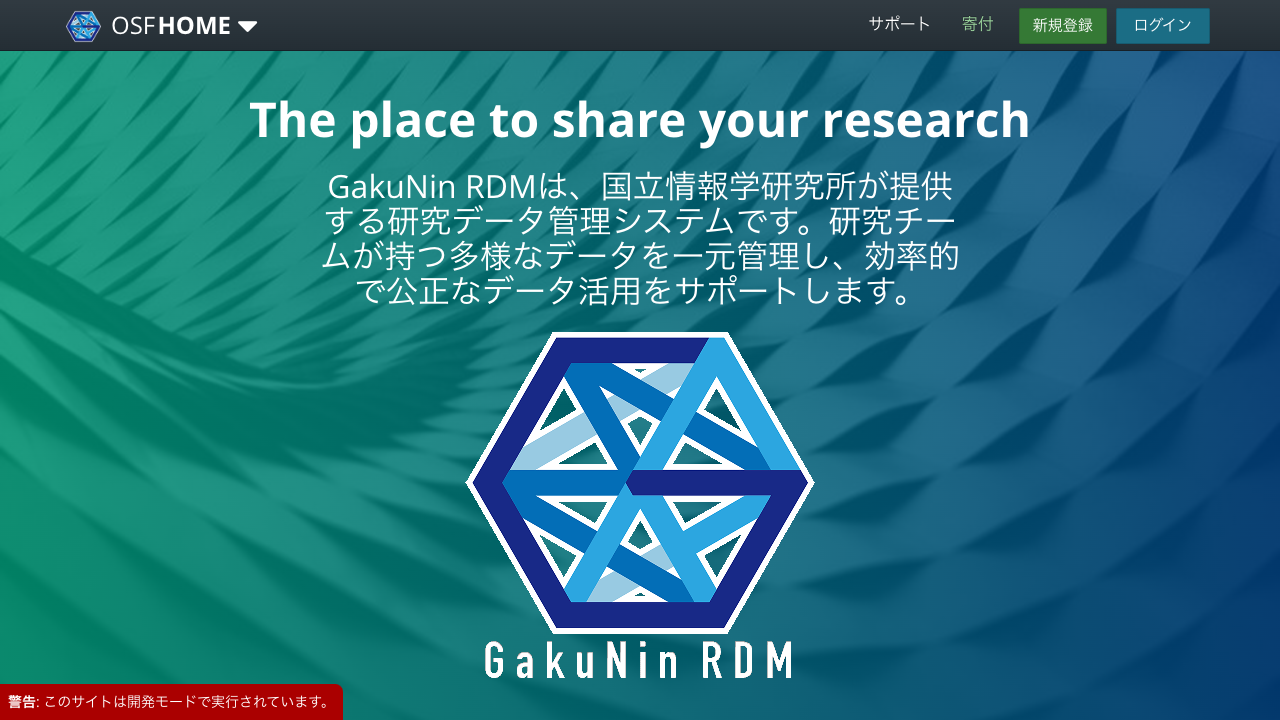

In [9]:
import time

async def _step(page):
    await page.goto(rdm_url)

    # 同意する をクリック
    await page.locator('//button[text() = "同意する"]').click()

    # 同意する が表示されなくなったことを確認
    await expect(page.locator('//button[text() = "同意する"]')).to_have_count(0, timeout=500)

await run_pw(_step)

## ログイン情報を用いてGakuNin RDMにログインする

(IdPに関するログイン情報が与えられた場合、)
GakuNin Embeded DSのプルダウンを展開し、IdPリストから指定されたIdPを選択する。その後、アカウントのID/Passwordを入力して「Login」ボタンを押下する。

(IdPが指定されていない場合、)
CASのログイン操作を実施する。

Start epoch: 1757283906.409528 seconds


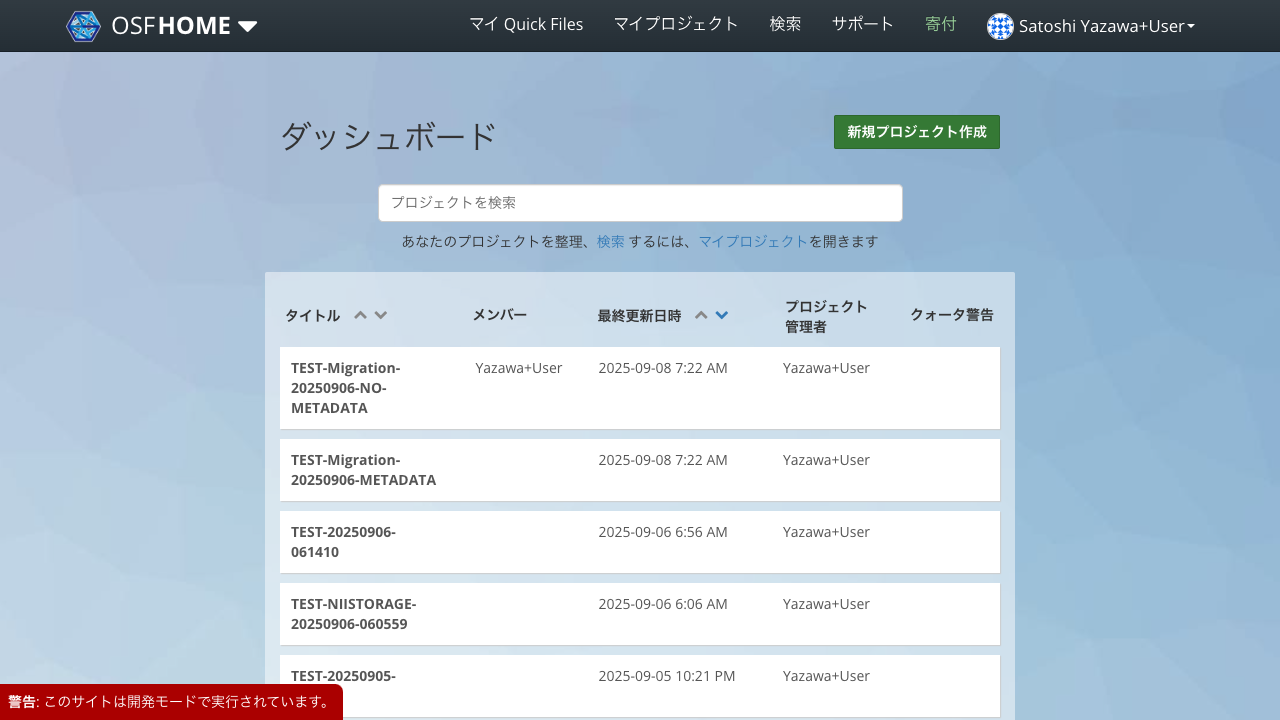

In [10]:
import scripts.grdm
importlib.reload(scripts.grdm)

async def _step(page):
    await scripts.grdm.login(
        page, idp_name_1, idp_username_1, idp_password_1, transition_timeout=transition_timeout
    )

    # プロジェクト一覧が表示されることを確認
    await expect(page.locator(f'//*[text() = "{rdm_project_name_w_metadata}"]')).to_be_visible(timeout=transition_timeout)

await run_pw(_step)

## Metadata紐付け済みのプロジェクトに移動する

プロジェクト一覧から指定されたプロジェクトを選択し、プロジェクト詳細ページに移動する。

Start epoch: 1757283912.785999 seconds


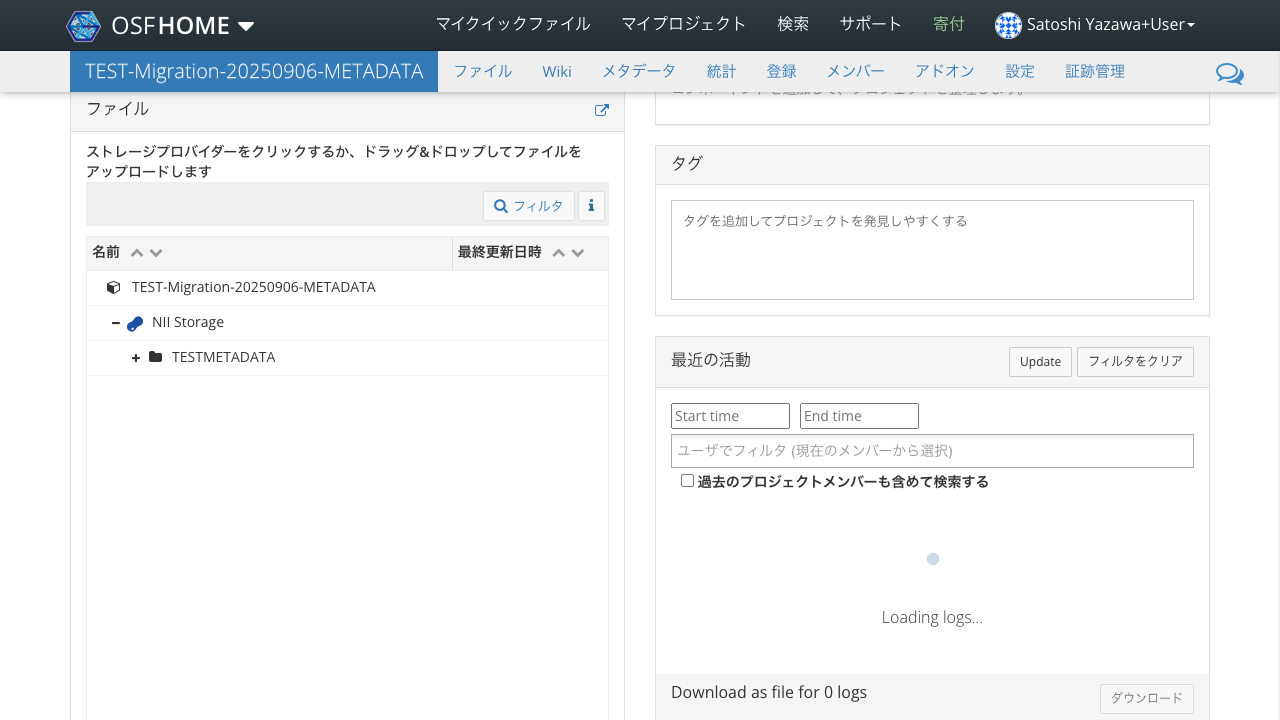

In [11]:
async def _step(page):
    await page.locator(f'//*[@data-test-dashboard-item-title and text()="{rdm_project_name_w_metadata}"]').click()        

    await expect(page.locator('//a[text() = "アドオン"]')).to_be_visible(timeout=transition_timeout)
    await expect(grdm.get_select_expanded_storage_title_locator(page, target_storage_name)).to_be_visible(timeout=transition_timeout)
    time.sleep(1)

    await page.locator('//h3[text()="最近の活動"]').click()
    await expect(page.locator(f'//a[contains(text(), "メタデータ")]')).to_be_visible(timeout=10000)

await run_pw(_step)

## プロジェクトダッシュボードの上部メニューから「メタデータ」をクリックする

メタデータの一覧ページが表示されること

Start epoch: 1757284036.234582 seconds


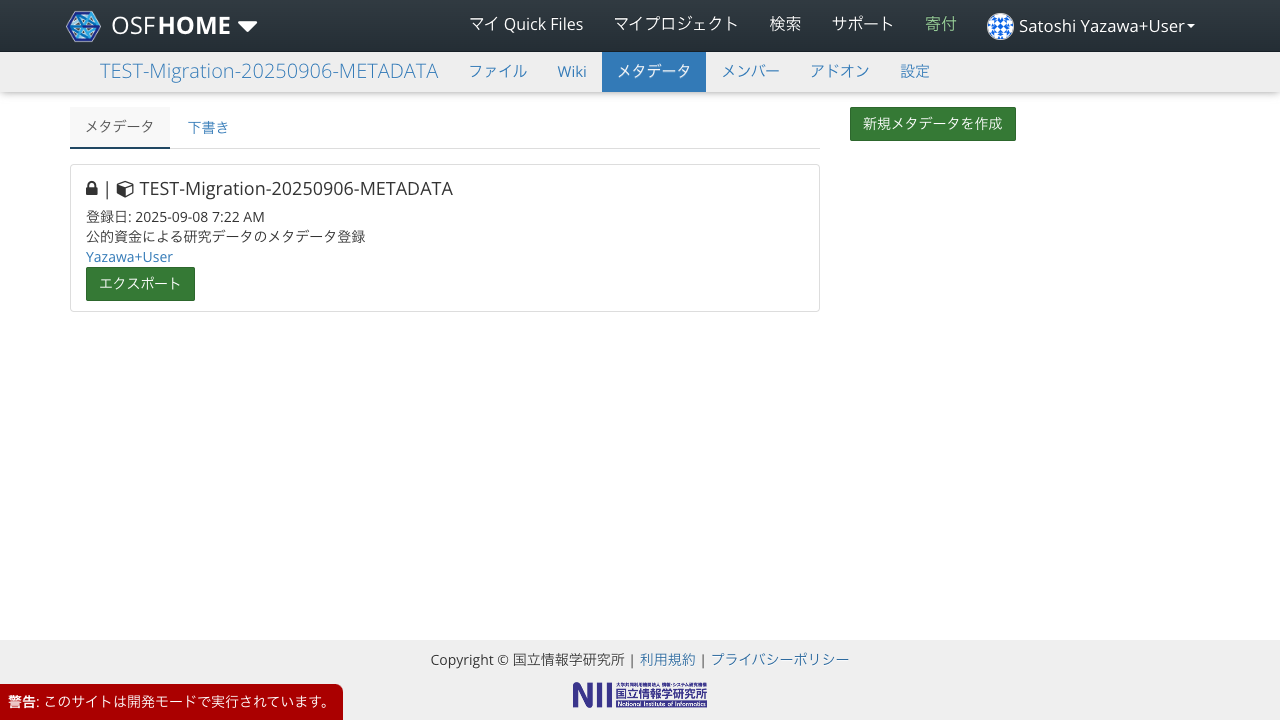

In [ ]:
async def _step(page):
    await page.locator(f'//a[contains(text(), "メタデータ")]').click()
    await expect(page.locator('//*[@data-test-new-metadata-button]')).to_be_visible(timeout=10000)
    await expect(page.locator('//button[@data-test-registration-card-export]')).to_be_enabled(timeout=transition_timeout)

await run_pw(_step)

## 「エクスポート」をクリックする

言語選択画面が表示されること

Start epoch: 1757284048.7220092 seconds


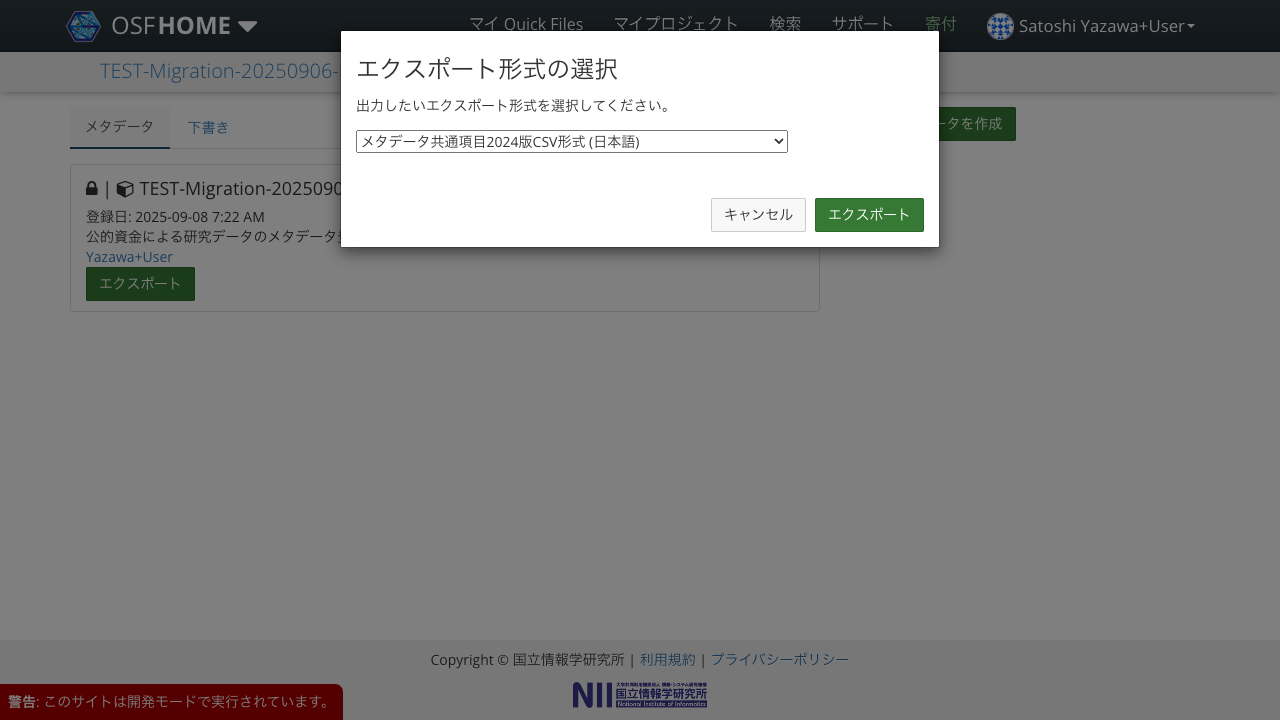

In [14]:
async def _step(page):
    await page.locator('//button[@data-test-registration-card-export]').click()
    
    await expect(page.locator('//select[@id = "registration-report-format-selection"]')).to_be_enabled(timeout=30000)
    time.sleep(1)

await run_pw(_step)

## 「メタデータ共通項目2024版CSV形式 (日本語)」を選択し「エクスポート」をクリックする

CSVファイルがダウンロードされ、かつ、このCSVはUTF-16 BOM付きファイルで2行のファイルとなっていること。
データの分野が「情報通信」となっていること

Start epoch: 1757284053.0717282 seconds


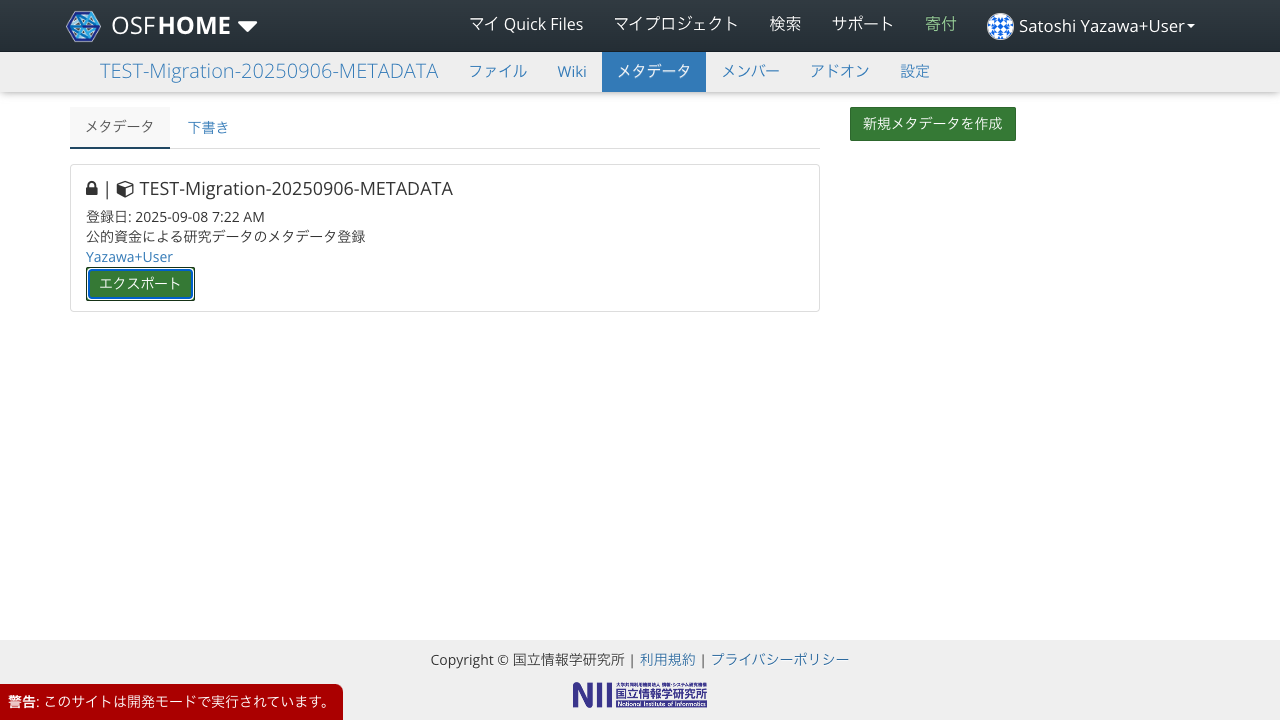

In [15]:
async def _step(page):
    await page.locator('//select[@id = "registration-report-format-selection"]').select_option('メタデータ共通項目2024版CSV形式 (日本語)')
    download_future = page.wait_for_event('download')
    await page.locator('//button[@data-test-registration-report-submit]').click()
    download = await download_future
    await download.save_as(os.path.join(work_dir, 'report.csv'))
    assert os.path.exists(os.path.join(work_dir, 'report.csv'))

await run_pw(_step)

In [16]:
import pandas as pd
df = pd.read_csv(os.path.join(work_dir, 'report.csv'), encoding='utf-16')
df

In [17]:
import re
import numpy as np

assert_values = {
    '資金配分機関情報': '国立研究開発法人科学技術振興機構',
    '体系的番号におけるプログラム情報コード': 'ABC',
    'プログラム名': 'サンプルプログラム',
    '体系的番号': 123456789,
    'プロジェクト名': 'サンプルメタデータプロジェクト',
    'データNo.': f'files/dir/{target_storage_id}/TESTMETADATA/',
    'データの名称': 'テストデータ',
    '掲載日・掲載更新日': '2022-05-25',
    'データの説明': '自動テストによって作成されたメタデータです。',
    'データの分野': '情報通信',
    'データ種別': 'データセット',
    '概略データ量': '0B',
    '管理対象データの利活用・提供方針 (有償/無償)': '無償',
    '管理対象データの利活用・提供方針(ライセンス)': 'CCBY',
    '管理対象データの利活用・提供方針(引用方法等)': '利用方針をここに記載します。',
    'アクセス権': '公開',
    '公開予定日 (公開期間猶予の場合)': np.nan,
    'リポジトリ情報': 'テストリポジトリ',
    'リポジトリURL・DOIリンク': re.compile(r'https:\/\/[^\/]+\/[^\/]+\/files\/dir\/' + target_storage_id + r'\/TESTMETADATA\/'),
    'データ作成者': '情報太郎',
    'データ作成者の研究者番号': 123456789,
    'データ管理機関': '国立情報学研究所',
    'データ管理機関コード': 'https://ror.org/DUMMY',
    'データ管理者': '情報花子',
    'データ管理者の研究者番号': 123456789,
    'データ管理者の所属組織名': 'テストセンター',
    'データ管理者の所属機関の連絡先住所': 'テスト住所',
    'データ管理者の所属機関の連絡先電話番号': '000-0000-0000',
    'データ管理者の所属機関の連絡先メールアドレス': 'test@test.nii.ac.jp',
    '備考': '日本語による備考です。'
}
for column in ['資金配分機関情報',
 '体系的番号におけるプログラム情報コード',
 'プログラム名',
 '体系的番号',
 'プロジェクト名',
 'データNo.',
 'データの名称',
 '掲載日・掲載更新日',
 'データの説明',
 'データの分野',
 'データ種別',
 '概略データ量',
 '管理対象データの利活用・提供方針 (有償/無償)',
 '管理対象データの利活用・提供方針(ライセンス)',
 '管理対象データの利活用・提供方針(引用方法等)',
 'アクセス権',
 '公開予定日 (公開期間猶予の場合)',
 'リポジトリ情報',
 'リポジトリURL・DOIリンク',
 'データ作成者',
 'データ作成者の研究者番号',
 'データ管理機関',
 'データ管理機関コード',
 'データ管理者',
 'データ管理者の研究者番号',
 'データ管理者の所属組織名',
 'データ管理者の所属機関の連絡先住所',
 'データ管理者の所属機関の連絡先電話番号',
 'データ管理者の所属機関の連絡先メールアドレス',
 '備考']:
    assert column in assert_values, (column)
    if isinstance(assert_values[column], float) and np.isnan(assert_values[column]):
        assert np.isnan(df[column].values[0]), (column, assert_values[column], df[column].values[0])
        continue
    if hasattr(assert_values[column], 'match'):
        assert assert_values[column].match(df[column].values[0]), (column, assert_values[column], df[column].values[0])
        continue
    assert df[column].values[0] == assert_values[column], (column, assert_values[column], df[column].values[0])

In [18]:
!rm {work_dir}/report.csv

## 「エクスポート」をクリックする

言語選択画面が表示されること

Start epoch: 1757284069.488238 seconds


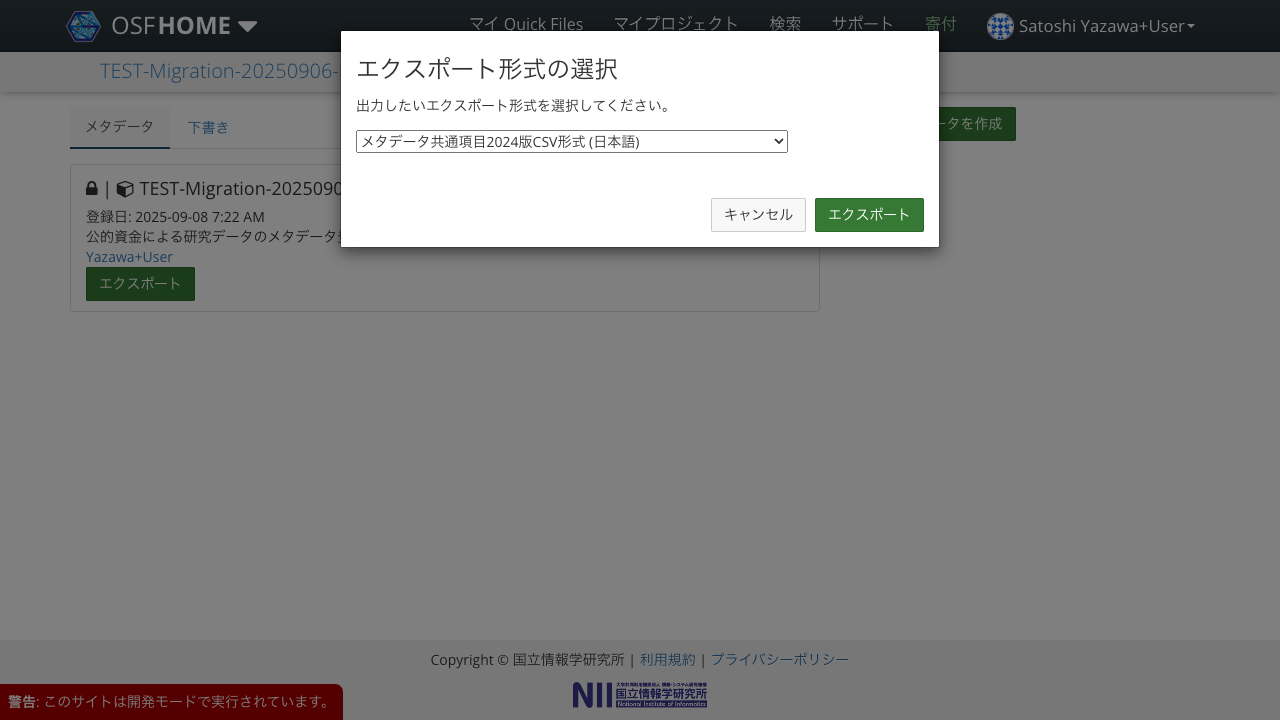

In [19]:
async def _step(page):
    await page.locator('//button[@data-test-registration-card-export]').click()
    
    await expect(page.locator('//select[@id = "registration-report-format-selection"]')).to_be_enabled(timeout=1000)
    time.sleep(1)

await run_pw(_step)

## 「Common Metadata Elements 2024 edition CSV format (English)」を選択し「エクスポート」をクリックする

CSVファイルがダウンロードされ、かつ、このCSVはUTF-16 BOM付きファイルで2行のファイルとなっていること。
Research fieldが「Informatics」となっていること

Start epoch: 1757284074.8337111 seconds


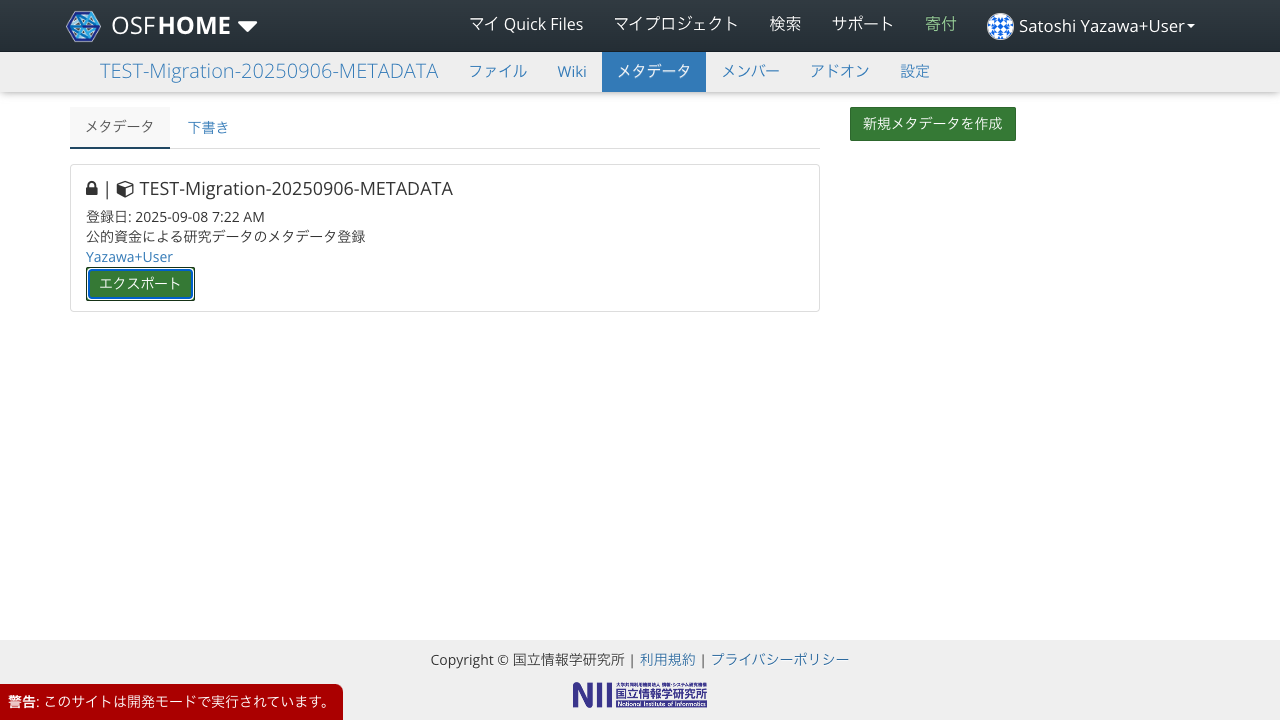

In [20]:
async def _step(page):
    await page.locator('//select[@id = "registration-report-format-selection"]').select_option('Common Metadata Elements 2024 edition CSV format (English)')
    download_future = page.wait_for_event('download')
    await page.locator('//button[@data-test-registration-report-submit]').click()
    download = await download_future
    await download.save_as(os.path.join(work_dir, 'report.csv'))
    assert os.path.exists(os.path.join(work_dir, 'report.csv'))

await run_pw(_step)

In [21]:
import pandas as pd
df = pd.read_csv(os.path.join(work_dir, 'report.csv'), encoding='utf-16')
df

In [22]:
list(df.columns)

['Funder',
 'Funding stream code in Japan Grant Number',
 'Program name',
 'Japan Grant Number',
 'Project name',
 'Data No.',
 'Title',
 'Date (Issued / Updated)',
 'Description',
 'Research field',
 'Data type',
 'File size',
 'Data utilization and provision policy(Free/Consideration)',
 'Data utilization and provision policy(License)',
 'Data utilization and provision policy(citation information)',
 'Access rights',
 'Publication date (for embargoed access)',
 'Repository information',
 'Repository URL/ DOI link',
 'Creator Name',
 'Creator name identifier (e-Rad)',
 'Hosting institution',
 'Hosting institution Identifier',
 'Data manager',
 'Data manager identifier (e-Rad)',
 'Contact organization of data manager',
 'Contact address of data manager',
 'Contact phone number of data manager',
 'Contact mail address of data manager',
 'Remarks']

In [23]:
import re
import numpy as np

assert_values = {
    'Funder': 'Japan Science and Technology Agency',
    'Funding stream code in Japan Grant Number': 'ABC',
    'Program name': 'Sample Program',
    'Japan Grant Number': 123456789,
    'Project name': 'Sample Metadata Project',
    'Data No.': f'files/dir/{target_storage_id}/TESTMETADATA/',
    'Title': 'Test Data',
    'Date (Issued / Updated)': '2022-05-25',
    'Description': 'Metadata created by automated testing.',
    'Research field': 'Informatics',
    'Data type': 'dataset',
    'File size': '0B',
    'Data utilization and provision policy(Free/Consideration)': 'free',
    'Data utilization and provision policy(License)': 'CCBY',
    'Data utilization and provision policy(citation information)': 'The policy for use is described here.',
    'Access rights': 'open access',
    'Publication date (for embargoed access)': np.nan,
    'Repository information': 'Test Repository',
    'Repository URL/ DOI link': re.compile(r'https:\/\/[^\/]+\/[^\/]+\/files\/dir\/' + target_storage_id + r'\/TESTMETADATA\/'),
    'Creator Name': 'Taro Joho',
    'Creator name identifier (e-Rad)': 123456789,
    'Hosting institution': 'National Institute of Informatics',
    'Hosting institution Identifier': 'https://ror.org/DUMMY',
    'Data manager': 'Hanako Joho',
    'Data manager identifier (e-Rad)': 123456789,
    'Contact organization of data manager': 'Test Center',
    'Contact address of data manager': 'Test Address',
    'Contact phone number of data manager': '000-0000-0000',
    'Contact mail address of data manager': 'test@test.nii.ac.jp',
    'Remarks': 'Remarks in English.'
}
for column in ['Funder',
 'Funding stream code in Japan Grant Number',
 'Program name',
 'Japan Grant Number',
 'Project name',
 'Data No.',
 'Title',
 'Date (Issued / Updated)',
 'Description',
 'Research field',
 'Data type',
 'File size',
 'Data utilization and provision policy(Free/Consideration)',
 'Data utilization and provision policy(License)',
 'Data utilization and provision policy(citation information)',
 'Access rights',
 'Publication date (for embargoed access)',
 'Repository information',
 'Repository URL/ DOI link',
 'Creator Name',
 'Creator name identifier (e-Rad)',
 'Hosting institution',
 'Hosting institution Identifier',
 'Data manager',
 'Data manager identifier (e-Rad)',
 'Contact organization of data manager',
 'Contact address of data manager',
 'Contact phone number of data manager',
 'Contact mail address of data manager',
 'Remarks']:
    assert column in assert_values, (column)
    if isinstance(assert_values[column], float) and np.isnan(assert_values[column]):
        assert np.isnan(df[column].values[0]), (column, assert_values[column], df[column].values[0])
        continue
    if hasattr(assert_values[column], 'match'):
        assert assert_values[column].match(df[column].values[0]), (column, assert_values[column], df[column].values[0])
        continue
    assert df[column].values[0] == assert_values[column], (column, assert_values[column], df[column].values[0])

In [24]:
!rm {work_dir}/report.csv

## プロジェクトを削除する

Start epoch: 1757284117.2994728 seconds
Banneker


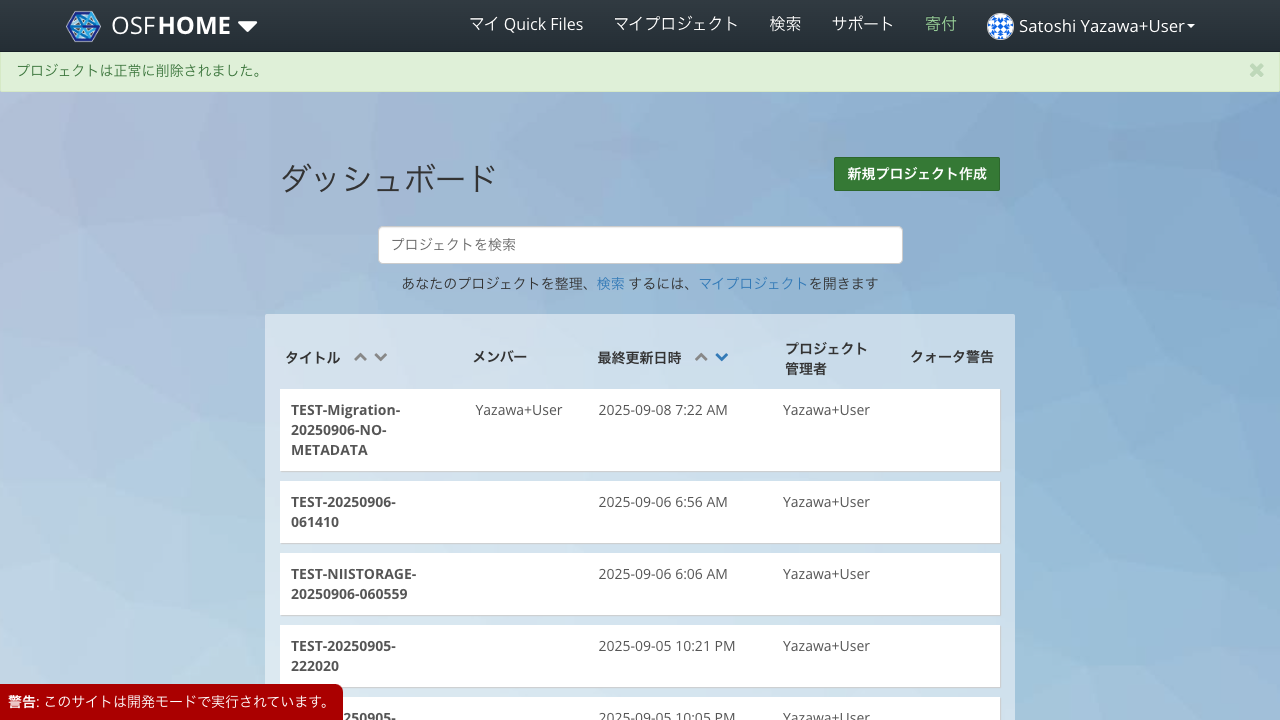

In [25]:
async def _step(page):
    await scripts.grdm.delete_project(page)
    
    await expect(page.locator('//*[text() = "プロジェクト管理者"]')).to_be_visible(timeout=transition_timeout)

await run_pw(_step)

## Metadata未設定のプロジェクトに移動する

Start epoch: 1757284175.5168269 seconds


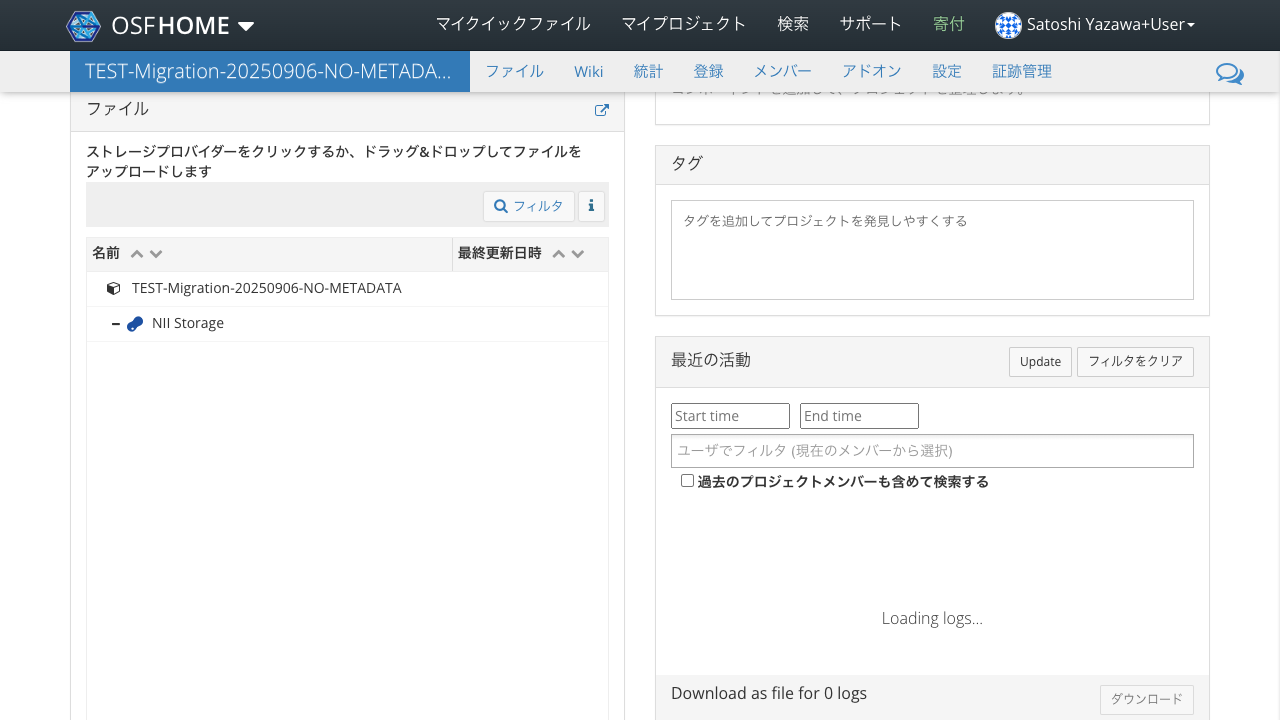

In [26]:
async def _step(page):
    await page.locator(f'//*[@data-test-dashboard-item-title and text()="{rdm_project_name_wo_metadata}"]').click()        

    await expect(page.locator('//a[text() = "アドオン"]')).to_be_visible(timeout=transition_timeout)
    await expect(grdm.get_select_expanded_storage_title_locator(page, target_storage_name)).to_be_visible(timeout=transition_timeout)
    time.sleep(1)

    await page.locator('//h3[text()="最近の活動"]').click()
    await expect(page.locator(f'//a[contains(text(), "メタデータ")]')).to_have_count(0, timeout=10000)

await run_pw(_step)

## プロジェクトダッシュボードの上部メニューから「アドオン」をクリックする

アドオン設定画面が表示されること

Start epoch: 1757284228.3417048 seconds


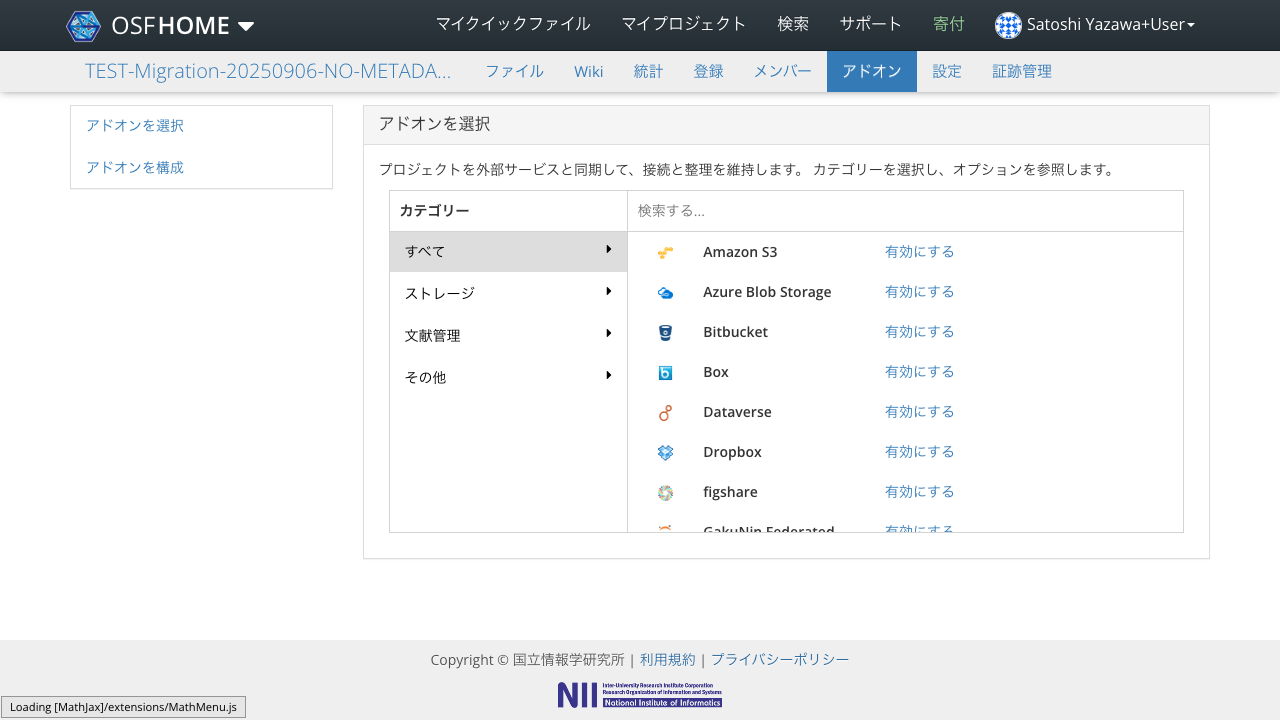

In [27]:
addon_name = 'Metadata'

async def _step(page):
    await page.locator('//a[text() = "アドオン"]').click()

    await expect(page.locator(f'//div[@full_name = "{addon_name}"]//descendant::a[text() = "有効にする"]')).to_be_visible(timeout=10000)

await run_pw(_step)

## 「アドオンを選択」のパネル内「Metadata」の行の「有効にする」をクリックする

「Metadataアドオン規約」のダイアログが表示されること

Start epoch: 1757284262.5624828 seconds


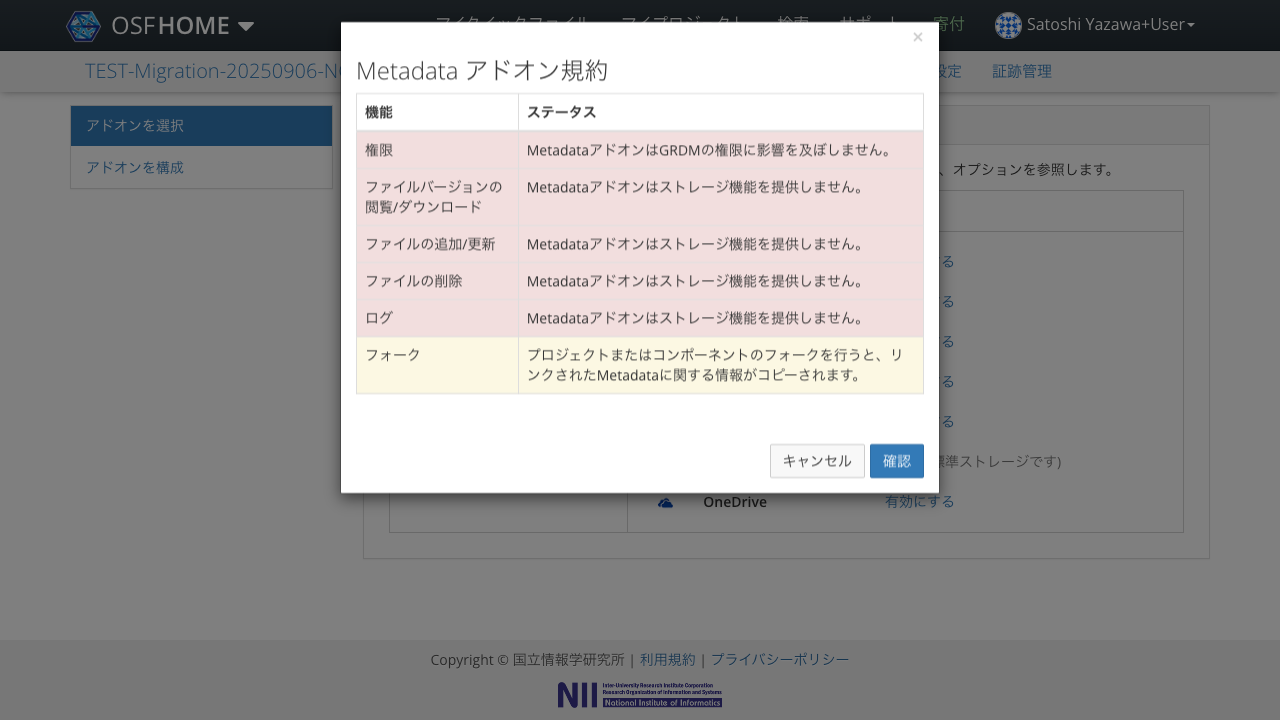

In [28]:
async def _step(page):
    await page.locator(f'//div[@full_name = "{addon_name}"]//descendant::a[text() = "有効にする"]').click()
    
    await expect(page.locator(f'//button[@data-bb-handler = "confirm"]')).to_be_visible(timeout=10000)

await run_pw(_step)

## 「確認」をクリックする

「アドオンを構成」のパネル内に「Metadata」の行が追加され、かつ、上部メニューに「メタデータ」タブが追加されること

Start epoch: 1757284291.783595 seconds


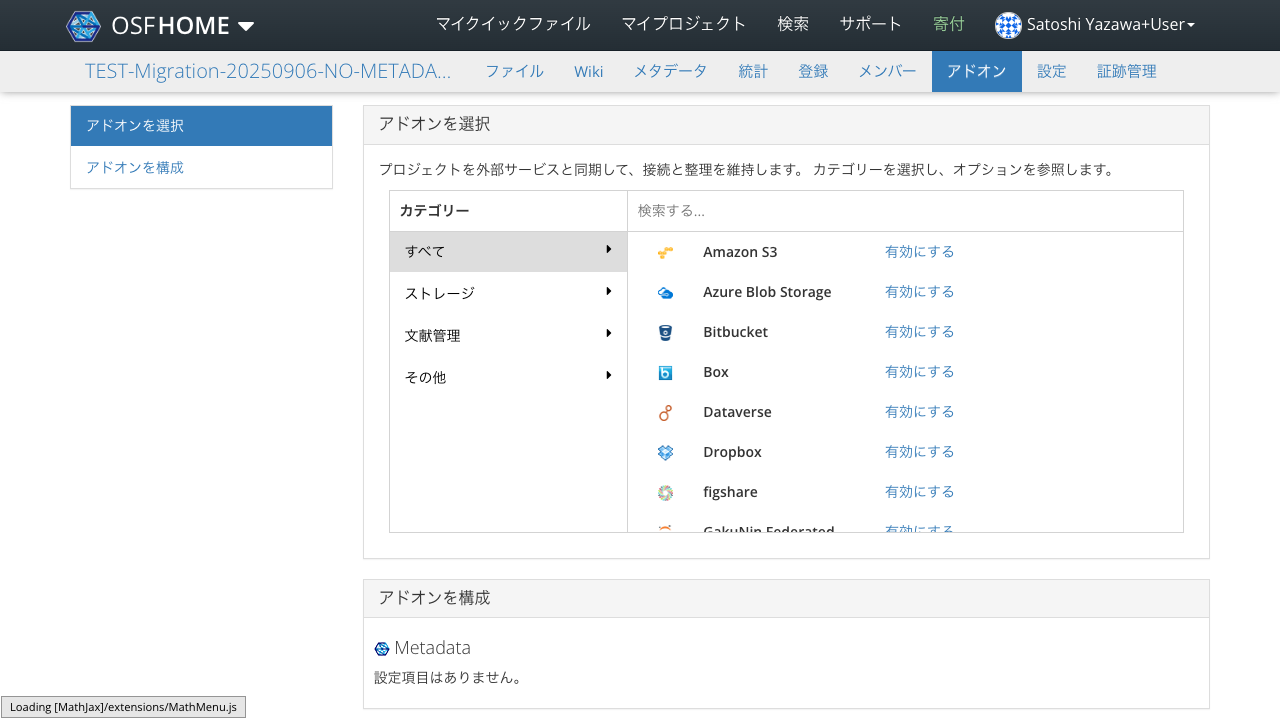

In [29]:
async def _step(page):
    await page.locator(f'//button[@data-bb-handler = "confirm"]').click()
    
    await expect(page.locator(f'//a[contains(text(), "メタデータ")]')).to_be_visible(timeout=10000)

await run_pw(_step)

## プロジェクトを削除する

Start epoch: 1757284337.159083 seconds
Pearce


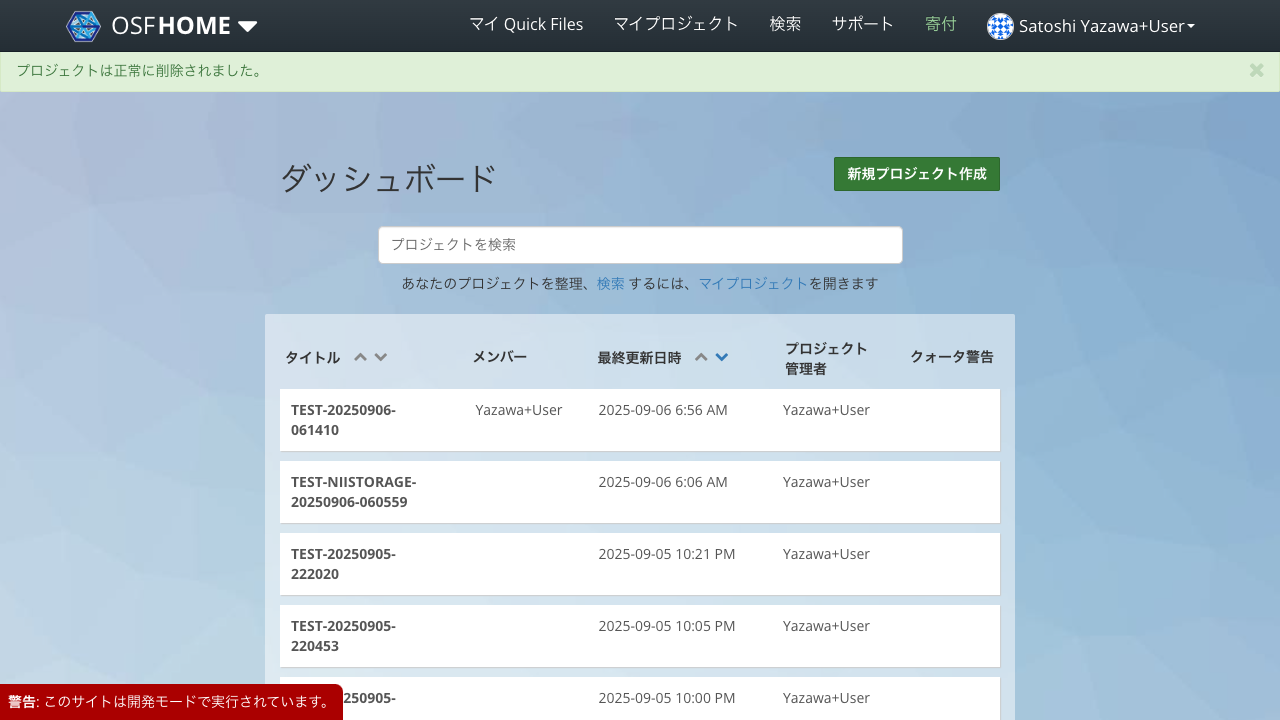

In [30]:
async def _step(page):
    await scripts.grdm.delete_project(page)
    
    await expect(page.locator('//*[text() = "プロジェクト管理者"]')).to_be_visible(timeout=transition_timeout)

await run_pw(_step)

終了処理を実施。

In [31]:
await finish_pw_context()

Video: /var/folders/m0/myy2ys0s3cl_73__2gw8fw140000gn/T/tmpniehqtfc/video-1.webm
HAR: /var/folders/m0/myy2ys0s3cl_73__2gw8fw140000gn/T/tmpniehqtfc/har.zip


スクリーンキャプチャ動画の取得に失敗しました。
Traceback (most recent call last):
  File "/Users/yazawa/workspace/nii-yamaji/RDM-e2e-test-nb/migrations/scripts/playwright.py", line 168, in _finish_pw_context
    shutil.copyfile(video_path, dest_video_path)
  File "/Users/yazawa/.pyenv/versions/3.11.5/lib/python3.11/shutil.py", line 256, in copyfile
    with open(src, 'rb') as fsrc:
         ^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: '/var/folders/m0/myy2ys0s3cl_73__2gw8fw140000gn/T/tmp41qv1t1z/videos/3111839b5dcefbf1af4f876c59ee3c17.webm'


In [32]:
!rm -fr {work_dir}